# 密歇根大学校园功率预测模型

本notebook实现了一个基于LSTM的功率预测模型，用于预测"密歇根"建筑的用电负荷。

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 数据集类定义

In [3]:
class MichiganPowerDataset(Dataset):
    def __init__(self, data, lookback=288, predict_size=48):  # 24小时=288个5分钟, 4小时=48个5分钟
        # 确保数据按时间排序
        self.data = data.sort_values('datetime').reset_index(drop=True)
        
        # 时间特征
        self.data['hour'] = pd.to_datetime(self.data['datetime']).dt.hour
        self.data['day_of_week'] = pd.to_datetime(self.data['datetime']).dt.dayofweek
        
        # 事件类型编码
        self.event_encoder = LabelEncoder()
        self.data['event_type_encoded'] = self.event_encoder.fit_transform(self.data['event_type'])
        
        # 归一化功率和调节幅度
        self.power_scaler = MinMaxScaler()
        self.change_scaler = MinMaxScaler()
        
        # 归一化功率数据
        power_data = self.data['power'].values.reshape(-1, 1)
        self.normalized_power = self.power_scaler.fit_transform(power_data)
        
        # 归一化调节幅度数据
        change_data = np.column_stack((self.data['up_change'], self.data['down_change']))
        self.normalized_changes = self.change_scaler.fit_transform(change_data)
        
        self.lookback = lookback
        self.predict_size = predict_size
    
    def __len__(self):
        return len(self.data) - self.lookback - self.predict_size + 1
    
    def __getitem__(self, idx):
        # 基础特征：功率
        x_power = self.normalized_power[idx:idx+self.lookback]
        
        # 时间特征
        x_hour = self.data['hour'].values[idx:idx+self.lookback]
        x_day = self.data['day_of_week'].values[idx:idx+self.lookback]
        
        # 事件特征
        x_event = self.data['event_type_encoded'].values[idx:idx+self.lookback]
        x_up_change = self.normalized_changes[idx:idx+self.lookback, 0]
        x_down_change = self.normalized_changes[idx:idx+self.lookback, 1]
        
        # 组合所有特征
        x = np.column_stack((
            x_power,
            x_hour/24.0,  # 归一化时间
            x_day/7.0,    # 归一化星期
            x_event/len(self.event_encoder.classes_),  # 归一化事件类型
            x_up_change,
            x_down_change
        ))
        
        # 获取目标序列
        y = self.normalized_power[idx+self.lookback:idx+self.lookback+self.predict_size]
        
        return torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1))

    def inverse_transform_power(self, normalized_power):
        return self.power_scaler.inverse_transform(normalized_power.reshape(-1, 1))

## 模型定义

In [4]:
class PowerPredictor(nn.Module):
    def __init__(self, input_features=6, hidden_size=64, num_layers=1, output_size=48):
        super(PowerPredictor, self).__init__()
        self.lstm = nn.LSTM(
            input_features, 
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # *2是因为双向LSTM
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc1(lstm_out[:, -1, :])  # 只使用最后一个时间步的输出
        out = self.relu(out)
        out = self.dropout(out)
        predictions = self.fc2(out)
        return predictions

In [5]:
class PowerPredictor(nn.Module):
    def __init__(self, input_features=6, hidden_size=128, output_size=48):
        super(PowerPredictor, self).__init__()
        self.flatten = nn.Flatten()  # 展平输入序列
        self.fc1 = nn.Linear(input_features * 288, hidden_size)  # 48是lookback长度
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU() 
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.flatten(x)  # 展平为 (batch_size, input_features * sequence_length)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


## 训练函数定义

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 10
    
    epoch_pbar = trange(num_epochs, desc='Training')
    for epoch in epoch_pbar:
        # 训练阶段
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} Training', 
                         leave=False, position=1)
        
        for batch_x, batch_y in train_pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
            train_pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} Validation', 
                       leave=False, position=1)
        
        with torch.no_grad():
            for batch_x, batch_y in val_pbar:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                val_loss += criterion(outputs, batch_y).item()
                
                val_pbar.set_postfix({'batch_loss': f'{val_loss/len(val_loader):.4f}'})
        
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        
        epoch_pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'val_loss': f'{val_loss:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_power_predictor.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("\nEarly stopping triggered")
                break
    
    print("\n训练完成！")
    return model

## 模型训练执行

In [7]:
print("正在加载数据...")
# 读取数据
df = pd.read_csv('/home/suruixian/Documents/Graduation_Thesis/explore/michigan_power_events.csv')
df

正在加载数据...


,datetime,power,event_id,event_type,up_change,down_change
0,2021-07-19 00:00:00,2735.0,NaN,N,0.0,0.0
1,2021-07-19 00:05:00,2727.3,NaN,N,0.0,0.0
2,2021-07-19 00:10:00,2712.4,NaN,N,0.0,0.0
3,2021-07-19 00:15:00,2699.9,NaN,N,0.0,0.0
4,2021-07-19 00:20:00,2703.8,NaN,N,0.0,0.0
...,...,...,...,...,...,...
21595,2021-10-01 23:35:00,9240.8,NaN,N,0.0,0.0
21596,2021-10-01 23:40:00,9281.3,NaN,N,0.0,0.0
21597,2021-10-01 23:45:00,9248.7,NaN,N,0.0,0.0
21598,2021-10-01 23:50:00,9291.1,NaN,N,0.0,0.0


In [8]:
# print("正在加载数据...")
# # 读取数据
# df = pd.read_csv('/home/suruixian/Documents/Graduation_Thesis/explore/michigan_power_events.csv')

print("正在准备数据集...")
# 创建数据集
dataset = MichiganPowerDataset(df)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
indices = list(range(len(dataset)))
train_dataset = torch.utils.data.Subset(dataset, indices[:train_size])
val_dataset = torch.utils.data.Subset(dataset, indices[train_size:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("正在初始化模型...")
# 初始化模型
model = PowerPredictor()

print("开始训练...")
# 训练模型
model = train_model(model, train_loader, val_loader)

正在准备数据集...
正在初始化模型...
开始训练...


Training:  80%|████████  | 40/50 [00:48<00:12,  1.22s/it, train_loss=0.0078, val_loss=0.0049, lr=0.000100]


Early stopping triggered

训练完成！


## 模型预测与可视化

In [9]:
all_times = df.copy()
all_times['datetime'] = pd.to_datetime(all_times['datetime'])
all_times.set_index('datetime',inplace=True)
all_times.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21600 entries, 2021-07-19 00:00:00 to 2021-10-01 23:55:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   power        21600 non-null  float64
 1   event_id     1170 non-null   float64
 2   event_type   21600 non-null  object 
 3   up_change    21600 non-null  float64
 4   down_change  21600 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1012.5+ KB


输入数据长度: 288, 需要长度: 288
特征形状: power=(288, 1), hour=(288,), day=(288,), event=(288,), changes=(288, 2)
组合后的输入特征形状: (288, 6)
转换为tensor后的形状: torch.Size([288, 6])
模型所在设备: cuda:0
预测结果形状: torch.Size([1, 48])
转换回实际值后的预测结果形状: (48, 1)
预测时间点数量: 48


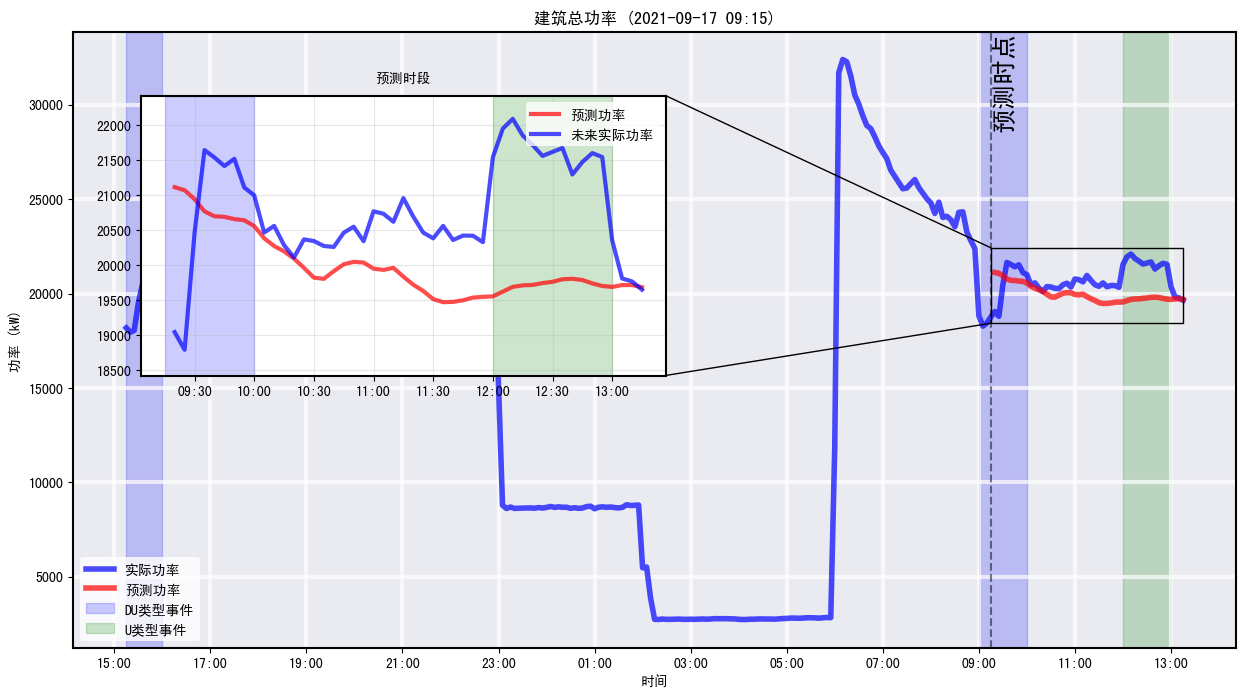

In [12]:
def plot_forecast(target_time = '2021-09-17 09:00:00', model=None, dataset=None):
    # 将输入的时间字符串转换为datetime对象
    target_time = pd.to_datetime(target_time)
    
    # 获取目标时间前12小时到后4小时的数据
    start_time = target_time - pd.Timedelta(hours=18)
    end_time = target_time + pd.Timedelta(hours=4)
    mask = (all_times.index >= start_time) & (all_times.index <= end_time)
    plot_data = all_times[mask]

    # 创建主图
    fig = plt.figure(figsize=(15, 8))
    main_ax = plt.gca()
    main_ax.set_facecolor('#EAEAF1')  # 浅蓝色背景
    # fig.patch.set_facecolor('#EAEAF1')  # 图形整体背景也设置为浅蓝色
    # 添加网格，设置为白色
    main_ax.grid(True, color='white', linewidth=3, alpha=0.7, zorder=0)
    
    
    # 为主图添加边框
    for spine in main_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        spine.set_visible(True)
    
    # 绘制主图的实际数据
    main_ax.plot(plot_data.index, plot_data['power'], 'b-', alpha=0.7, label='实际功率', linewidth=4)
    
    # 添加目标时间点的垂直线
    main_ax.axvline(x=target_time, color='black', linestyle='--', alpha=0.5)
    main_ax.text(target_time, main_ax.get_ylim()[1], '预测时点', 
                rotation=90, verticalalignment='top', color='black', fontsize=18)

    # 如果提供了模型和数据集，添加预测结果
    if model is not None and dataset is not None:
        try:
            # 获取输入数据（目标时间点前的lookback个数据点）
            input_data = all_times.loc[:target_time].tail(dataset.lookback)
            print(f"输入数据长度: {len(input_data)}, 需要长度: {dataset.lookback}")
            
            if len(input_data) >= dataset.lookback:
                # 构建输入特征
                x_power = dataset.power_scaler.transform(input_data['power'].values.reshape(-1, 1))
                x_hour = np.array(input_data.index.hour, dtype=float) / 24.0
                x_day = np.array(input_data.index.dayofweek, dtype=float) / 7.0
                x_event = dataset.event_encoder.transform(input_data['event_type']) / len(dataset.event_encoder.classes_)
                x_changes = dataset.change_scaler.transform(np.column_stack((input_data['up_change'], input_data['down_change'])))
                
                print(f"特征形状: power={x_power.shape}, hour={x_hour.shape}, day={x_day.shape}, "
                      f"event={x_event.shape}, changes={x_changes.shape}")
                
                # 组合特征
                x = np.column_stack((
                    x_power,
                    x_hour.reshape(-1, 1),
                    x_day.reshape(-1, 1),
                    x_event.reshape(-1, 1),
                    x_changes
                ))
                
                print(f"组合后的输入特征形状: {x.shape}")
                
                # 进行预测
                model.eval()
                with torch.no_grad():
                    x = torch.FloatTensor(x)
                    print(f"转换为tensor后的形状: {x.shape}")
                    
                    # 将输入数据移到与模型相同的设备上
                    device = next(model.parameters()).device
                    print(f"模型所在设备: {device}")
                    x = x.to(device)
                    
                    pred = model(x.unsqueeze(0))
                    print(f"预测结果形状: {pred.shape}")
                    
                    # 将预测结果移回CPU进行后续处理
                    pred = pred.cpu()
                    pred = dataset.inverse_transform_power(pred.numpy())
                    print(f"转换回实际值后的预测结果形状: {pred.shape}")
                
                # 生成预测时间点
                pred_times = pd.date_range(start=target_time, periods=len(pred)+1, freq='5min')[1:]
                print(f"预测时间点数量: {len(pred_times)}")
                
                # 在主图中绘制预测结果
                main_ax.plot(pred_times, pred.reshape(-1), 'r-', alpha=0.7, label='预测功率', linewidth=4)
                
                # 获取这段时间的真实值用于对比
                future_mask = (all_times.index > target_time) & (all_times.index <= end_time)
                future_actual = all_times[future_mask]
                # main_ax.plot(future_actual.index, future_actual['power'], 'b-', alpha=0.5, label='未来实际功率')

                # 创建子图
                inset_position = [0.17, 0.45, 0.35, 0.35]  # [left, bottom, width, height]
                inset_ax = fig.add_axes(inset_position)
                
                # 为子图添加边框
                for spine in inset_ax.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(1.5)
                    spine.set_visible(True)
                
                # 绘制放大视图中的数据
                inset_ax.plot(pred_times, pred.reshape(-1), 'r-', alpha=0.7, label='预测功率', linewidth = 3)
                inset_ax.plot(future_actual.index, future_actual['power'], 'b-', alpha=0.7, label='未来实际功率', linewidth = 3)
                
                # 设置放大子图的格式
                # 设置放大子图的格式
                # 设置放大子图的格式
                inset_ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0, 60, 30)))  # 每10分钟显示一个时间标签
                inset_ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 30)))   # 每5分钟显示一个小刻度
                inset_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                inset_ax.grid(True, which='major', alpha=0.3)  # 主网格线
                inset_ax.grid(True, which='minor', alpha=0.15)  # 次网格线
                inset_ax.set_title('预测时段', fontsize=10, pad=10)
                inset_ax.legend(loc='upper right', frameon=True, facecolor='white', edgecolor='none')

                # 添加连接线
                from matplotlib.patches import ConnectionPatch, Rectangle

                # 获取主图中预测时段的数据范围
                zoom_start = target_time
                zoom_end = target_time + pd.Timedelta(hours=4)
                
                # 获取预测时段的数据范围
                pred_mask = (plot_data.index >= zoom_start) & (plot_data.index <= zoom_end)
                pred_data = plot_data[pred_mask]
                
                # 获取预测时段的y轴范围
                if not pred_data.empty:
                    main_y_min = min(pred_data['power'].min(), pred.min())
                    main_y_max = max(pred_data['power'].max(), pred.max())
                    # 添加一些边距
                    y_margin = (main_y_max - main_y_min) * 0.1
                    main_y_min -= y_margin
                    main_y_max += y_margin
                    
                    # 在主图中添加矩形框标记预测时段
                    rect = Rectangle(
                        (mdates.date2num(zoom_start), main_y_min),
                        mdates.date2num(zoom_end) - mdates.date2num(zoom_start),
                        main_y_max - main_y_min,
                        fill=False,
                        edgecolor='black',
                        linestyle='-',
                        linewidth=1,
                        zorder=5
                    )
                    main_ax.add_patch(rect)
                    
                    # 设置子图的y轴范围与主图中框选区域一致
                    inset_ax.set_ylim(main_y_min, main_y_max)
                    
                    # 创建两条对角连接线
                    connections = [
                        # 左上角到右上角
                        ((mdates.date2num(zoom_start), main_y_max), 
                         (inset_ax.get_xlim()[1], inset_ax.get_ylim()[1])),
                        # 左下角到右下角
                        ((mdates.date2num(zoom_start), main_y_min), 
                         (inset_ax.get_xlim()[1], inset_ax.get_ylim()[0]))
                    ]
                    
                    # 添加连接线
                    for corner_main, corner_inset in connections:
                        con = ConnectionPatch(
                            xyA=corner_main,
                            xyB=corner_inset,
                            coordsA="data",
                            coordsB="data",
                            axesA=main_ax,
                            axesB=inset_ax,
                            color="black",
                            linestyle="-",
                            linewidth=1,
                            zorder=5
                        )
                        main_ax.add_artist(con)


                # 标记需求响应事件（在子图中）
                event_periods = plot_data[plot_data['event_type'] != 'N']
                event_colors = {'UD': 'red', 'DU': 'blue', 'U': 'green'}
                
                if not event_periods.empty:
                    for event_id in event_periods['event_id'].unique():
                        event_data = event_periods[event_periods['event_id'] == event_id]
                        event_start = event_data.index[0]
                        event_end = event_data.index[-1]
                        
                        # 检查事件是否与预测时段有重叠
                        if not (event_end < zoom_start or event_start > zoom_end):
                            event_type = event_data['event_type'].iloc[0]
                            color = event_colors.get(event_type, 'gray')
                            
                            # 计算事件在预测时段内的起止时间
                            plot_start = max(event_start, zoom_start)
                            plot_end = min(event_end, zoom_end)
                            
                            inset_ax.axvspan(plot_start, plot_end, 
                                           alpha=0.2, color=color)
        
        except Exception as e:
            import traceback
            print(f"预测出错: {str(e)}")
            print("详细错误信息:")
            print(traceback.format_exc())

    # 标记需求响应事件（在主图中）
    event_periods = plot_data[plot_data['event_type'] != 'N']
    event_colors = {'UD': 'red', 'DU': 'blue', 'U': 'green'}
    added_event_types = set()

    if not event_periods.empty:
        for event_id in event_periods['event_id'].unique():
            event_data = event_periods[event_periods['event_id'] == event_id]
            event_type = event_data['event_type'].iloc[0]
            color = event_colors.get(event_type, 'gray')
            
            if event_type not in added_event_types:
                main_ax.axvspan(event_data.index[0], event_data.index[-1], 
                             alpha=0.2, color=color, 
                             label=f'{event_type}类型事件')
                added_event_types.add(event_type)
            else:
                main_ax.axvspan(event_data.index[0], event_data.index[-1], 
                             alpha=0.2, color=color)

    # 设置主图的标题和标签
    main_ax.set_title(f'建筑总功率 ({target_time.strftime("%Y-%m-%d %H:%M")})')
    main_ax.set_xlabel('时间')
    main_ax.set_ylabel('功率 (kW)')
    # main_ax.grid(True)
    
    # 调整主图的图例位置和显示
    main_ax.legend(loc='lower left', frameon=True, facecolor='white', edgecolor='none')

    # 设置主图x轴格式
    main_ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    main_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 调整布局
    # plt.tight_layout()
    plt.show()

# 使用示例
target_time = '2021-09-17 09:15:00'
plot_forecast(target_time, model, dataset)  # 带预测结果的图